In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
from torch.optim import AdamW

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from pathlib import Path
import seaborn as sns
from sklearn.metrics import roc_auc_score
from uncalibrated_reasoning.utils import get_cache_dir

## Synthetic Data Experiments

### Data

We consider a minimal setting for analyzing RL algorithms with stochastic outcomes.

We simulate a dataset of 10,000 $(q_i, c_i, a_i)$ triples, representing questions, question categories, and binary answers. 
Questions are randomly assigned to one of 20 random categories.
For each category, a true category answer rate is sampled once from a uniform distribution: $p_c \sim \text{Uniform}(0, 1)$.
Answers are then sampled from the true answer rate for the question category: $a_i | q_i, c_i \sim \text{Bernoulli}(p_{c_i})$.

In [3]:
device = "cuda"
num_categories = 20
num_samples = 10_000
seed = 2

In [4]:
rng = np.random.default_rng(seed)
Q = np.arange(num_samples)
C = rng.choice(num_categories, size=(num_samples,))
c_probs = rng.uniform(0, 1, size=(num_categories,))
A_probs = c_probs[C]
A = rng.binomial(n=1, p=A_probs)

In [5]:
df = pd.DataFrame({"Q": Q, "C": C, "A_probs": A_probs, "A": A})

In [6]:
df

,Q,C,A_probs,A
0,0,16,0.390701,0
1,1,5,0.625971,1
2,2,2,0.070073,0
3,3,5,0.625971,0
4,4,8,0.709000,0
...,...,...,...,...
9995,9995,7,0.268210,1
9996,9996,18,0.899928,1
9997,9997,16,0.390701,0
9998,9998,3,0.372871,1


In [7]:
Q = torch.Tensor(Q).long().to(device)
C = torch.Tensor(C).long().to(device)
A = torch.Tensor(A).long().to(device)
A_probs = torch.Tensor(A_probs).float().to(device)

### Models

We define a minimal "language model" for the uncertainty prediction task. The model samples a single token representing the predicted probability given the question (categorical representing 0.01, 0.02, ..., 0.99), parameterized as $p_\theta(a_i=1|q_i)=p_\theta(a_i=1|c_i)$ with learnable logit parameters for each category / answer probability pair. For experiments with PPO, we define a value model that predicts $V(q_i, c_i) = \beta_{c_i}$ with learnable parameters $\beta$ for each category.

In [8]:
class PolicyModel(nn.Module):
    def __init__(self, T, n_prob_categories: int = 15):
        super().__init__()
        self.n_prob_categories = n_prob_categories
        self.T = T
        self.a_cat_given_t_logits = nn.Parameter(torch.zeros(self.T.max().item() + 1, n_prob_categories), requires_grad=True)
        
    @torch.no_grad()
    def generate(self, Q, n=1):
        a_cat_given_t_logits = self.a_cat_given_t_logits[self.T[Q]]
        A_cat_sampled = torch.distributions.Categorical(logits=a_cat_given_t_logits).sample((n,))
        return A_cat_sampled
    
    def log_prob(self, Q, A):
        T = self.T[Q]
        a_cat_given_t_logits = self.a_cat_given_t_logits[T]
        logprob_a_cat_given_t = torch.distributions.Categorical(logits=a_cat_given_t_logits).log_prob(A)
        return logprob_a_cat_given_t
    
class ValueModel(nn.Module):
    # used for PPO
    def __init__(self, T):
        super().__init__()
        self.T = T
        self.V_T = nn.Parameter(torch.zeros(self.T.max().item() + 1,), requires_grad=True)

    def forward(self, Q):
        pred_values = self.V_T[self.T[Q]]
        return pred_values

### Define RL algorithms

In [9]:
def compute_rl_update(
        algo: str,
        reward_key: str,
        model: PolicyModel, 
        optimizer: torch.optim.Optimizer, 
        Q: torch.Tensor,
        A: torch.Tensor, 
        value_model: ValueModel | None = None, 
        optimizer_value: torch.optim.Optimizer | None = None,
        n_steps: int = 1,
        n_rollouts: int = 10,
        clip_eps: float = 0.2,
        compute_rollout_metrics: bool = True,
):
    # validate inputs
    assert algo in ("REINFORCE", "PPO", "RLOO", "GRPO", "GRPO_no_std")
    assert (value_model is None) == (optimizer_value is None)
    assert (algo == "PPO") == (value_model is not None)
    assert reward_key in ("log_likelihood",)

    # 1. sample "rollouts"
    A_cat_sampled = model.generate(Q, n=n_rollouts)
    A_prob_sampled = cat_to_prob(A_cat_sampled, model.n_prob_categories)

    # 2. compute original model log_prob for rollout (used for ratio in off policy updates)
    with torch.no_grad():
        A_cat_log_probs_original = model.log_prob(Q, A_cat_sampled).detach()

    # 3. compute rewards
    R = compute_reward(reward_key, A, A_prob_sampled)

    # 4. estimate advantage
    if algo != "PPO":
        adv = compute_advantage(algo, R)
    else:        
        # PPO only
        value_pred = value_model(Q)
        adv = compute_advantage(algo, R, value_pred=value_pred.detach())

        # update value model
        optimizer_value.zero_grad()
        critic_loss = nn.functional.mse_loss(value_pred.squeeze(), R.squeeze())
        critic_loss.backward()
        optimizer_value.step()

    # prepare for actor updates
    optimizer.zero_grad()
    step_metrics = defaultdict(list)
    step = 0

    # rollout metrics
    if compute_rollout_metrics:
        labels_numpy = A.float().detach().cpu().expand((n_rollouts, -1)).numpy().reshape(-1)
        preds_numpy = A_prob_sampled.detach().cpu().numpy().reshape(-1)
        append_step_metric(step_metrics, "reward_mean", R.mean().detach().cpu().item(), step)
        append_step_metric(step_metrics, "pred_entropy", compute_bernoulli_entropy(A_prob_sampled).mean().detach().cpu().item(), step)
        append_step_metric(step_metrics, "accuracy", ((A_prob_sampled > 0.5) == (A.float() > 0.5).reshape(1, -1)).float().mean().detach().cpu().item(), step)
        append_step_metric(step_metrics, "auroc", roc_auc_score(labels_numpy, preds_numpy), step)
        append_step_metric(step_metrics, "ece", expected_calibration_score(labels_numpy, preds_numpy), step)

    if algo == "PPO":
        append_step_metric(step_metrics, "value_loss", critic_loss.detach().cpu().item(), step)

    # perform actor updates
    for step in range(n_steps):
        # 5. compute current model log_probs
        A_cat_log_probs = model.log_prob(Q, A_cat_sampled)

        # 6. compute log probs ratio
        A_cat_probs_ratio = torch.exp(A_cat_log_probs - A_cat_log_probs_original)

        # 7. compute clipped surrogate objective
        unclipped = A_cat_probs_ratio * adv
        clipped = torch.clip(A_cat_probs_ratio, 1 - clip_eps, 1 + clip_eps) * adv
        stacked = torch.stack([clipped, unclipped], dim=-1)
        idx = torch.argmin(stacked, dim=-1)
        pg_loss = -(stacked[:,idx]).mean()
        frac_clipped = idx.float().mean()
        pg_loss = -(A_cat_probs_ratio * adv).mean()

        # 8. compute estimated policy gradient and perform update
        pg_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        append_step_metric(step_metrics, "frac_clipped", frac_clipped.detach().cpu().item(), step)
        append_step_metric(step_metrics, "pg_loss", pg_loss.detach().cpu().item(), step)

    step_metrics = pd.DataFrame(step_metrics)
    return step_metrics

def compute_reward(reward_key, A, A_prob_sampled):
    if reward_key == "log_likelihood":
        A = A.float()
        reward = A * torch.log(A_prob_sampled) + (1 - A) * torch.log(1 - A_prob_sampled)
    else:
        raise ValueError("Unknown reward key", reward_key)
    return reward

def compute_group_normalized_advantage(R, std_normalize=True, eps=1e-5):
    mean = R.mean(0, keepdim=True)
    std = R.std(0, keepdim=True)
    advantage = R - mean
    if std_normalize:
        advantage = advantage / (std + eps)
    return advantage

def compute_advantage(algo, R, value_pred=None, eps=1e-5):
    if algo == "REINFORCE":
        adv = R
    elif algo == "RLOO":
        mean_loo = R.mean(0, keepdim=True) - R / R.shape[0]
        adv = R - mean_loo
    elif algo == "GRPO_no_std":
        adv = R - R.mean(0, keepdim=True)
    elif algo == "GRPO":
        mean = R.mean(0, keepdim=True)
        std = R.std(0, keepdim=True)
        adv = (R - mean) / (std + eps)
    elif algo == "PPO":
        adv = R - value_pred
    else:
        raise ValueError("Unknown algo", algo)
    return adv

def cat_to_prob(A_cat, n_prob_categories):
    c_to_p = torch.linspace(0.01, 0.99, n_prob_categories, device=A_cat.device)
    return c_to_p[A_cat]

def compute_bernoulli_entropy(probs):
    term1 = -probs * torch.log2(probs)
    term2 = -(1-probs) * torch.log2(1-probs)
    return term1 + term2

def append_step_metric(metrics, name, value, step):
    metrics["step"].append(step)
    metrics["metric"].append(name)
    metrics["value"].append(value)

def expected_calibration_score(targets, preds, n_bins=10):
    df = pd.DataFrame({"pred": preds, "target": targets})
    df["pred_bin"] = pd.cut(df["pred"], np.linspace(0, 1, n_bins+1))
    grouped = df.groupby("pred_bin", observed=True)
    bin_mean_pred = grouped["pred"].mean()
    bin_mean_target = grouped["target"].mean()
    bin_counts = grouped["target"].count()

    bin_counts_normalized = bin_counts / df.shape[0]

    ece = (bin_counts_normalized * (bin_mean_pred - bin_mean_target).abs())
    ece = ece.sum()
    return ece

### Training infra (optimization loop + store / load results)

In [ ]:
# note: if running at the same time as perturbation experiments, Ray can mess with local paths
# you can hardcode the cache dir to get around this
cache_dir = get_cache_dir()
# cache_dir = Path("/lfs/local/0/mbereket/perturb_reasoning/data_cache/")
out_dir = cache_dir / "synthetic_experiments"
out_dir.mkdir(exist_ok=True, parents=True)

fig_dir = Path("images/prediction_v3/")
fig_dir.mkdir(exist_ok=True, parents=True)

In [11]:
def run_experiment(Q, C, A, algo: str, total_steps: int, n_rollouts: int, steps_per_rollout: int, lr: float, out_dir: Path, reward_key: str ="log_likelihood", clip_eps: float = 0.2, lr_value: float | None = None, recompute=False, seed: int = 0):
    results_dir = get_experiment_dir(algo, total_steps, n_rollouts, steps_per_rollout, lr, reward_key, lr_value, clip_eps, seed, out_dir)
    results_dir.mkdir(exist_ok=True, parents=True)

    pred_path = results_dir / "pred.pq"
    metrics_path = results_dir / "metrics.pq"
    checkpoint_path = results_dir / "model.pt"
    
    if recompute or not pred_path.exists():
        torch.random.manual_seed(seed)
        model, metrics = fit_model(Q, C, A, algo, total_steps, n_rollouts, steps_per_rollout, lr, reward_key, clip_eps, lr_value)
        pred_df = get_prediction_dataframe(model, Q, df)

        metrics.to_parquet(metrics_path)
        pred_df.to_parquet(pred_path)
        torch.save(model.state_dict(), checkpoint_path)

    metrics = pd.read_parquet(metrics_path)
    pred_df = pd.read_parquet(pred_path)
    model = load_model(checkpoint_path, C)

    return {"model": model, "metrics": metrics, "preds": pred_df}

def fit_model(Q, C, A, algo, total_steps, n_rollouts, steps_per_rollout, lr, reward_key, clip_eps, lr_value):
    model = PolicyModel(C, n_prob_categories=99).to(device)
    optimizer = AdamW(model.parameters(), lr=lr)

    if algo == "PPO":
        value_model = ValueModel(C).to(device)
        optimizer_value = AdamW(value_model.parameters(), lr=lr_value)
    else:
        value_model = None
        optimizer_value = None

    metrics = []
    for i in tqdm(range(total_steps // steps_per_rollout)):
        compute_rollout_metrics = i % 10 == 0
        curr_metrics = compute_rl_update(algo, reward_key, model, optimizer, Q, A, value_model, optimizer_value, n_steps=steps_per_rollout, n_rollouts=n_rollouts, clip_eps=clip_eps, compute_rollout_metrics=compute_rollout_metrics)
        curr_metrics["step"] = curr_metrics["step"] + (i * steps_per_rollout)
        metrics.append(curr_metrics)
    metrics = pd.concat(metrics)

    return model, metrics

def get_prediction_dataframe(model, Q, df):
    A_cat_sampled = model.generate(Q, n=100)
    A_probs_sampled = cat_to_prob(A_cat_sampled, model.n_prob_categories).mean(0)
    pred_df = df.copy()
    pred_df["A_probs_pred"] = A_probs_sampled.cpu().numpy()
    return pred_df

def load_model(path, C):
    # TODO: store C with model?
    model = PolicyModel(C, n_prob_categories=99)
    ckpt = torch.load(path)
    model.load_state_dict(ckpt)
    return model

def get_experiment_dir(algo, total_steps, n_rollouts, steps_per_rollout, lr, reward_key, clip_eps, lr_value, seed, out_dir):
    name_pieces = dict(algo=algo, total_steps=total_steps, n_rollouts=n_rollouts, steps_per_rollout=steps_per_rollout, lr=lr, reward_key=reward_key, clip_eps=clip_eps, lr_value=lr_value, seed=seed)
    name = []
    for k, v in name_pieces.items():
        name += [k, str(v)]
    name = "-".join(name)
    results_dir = out_dir / name
    return results_dir

In [12]:
def compute_expected_calibration_error(targets, preds, n_bins=10):
    df = pd.DataFrame({"pred": preds, "target": targets})
    df["pred_bin"] = pd.cut(df["pred"], np.linspace(0, 1, n_bins+1))
    bin_mean_pred = df.groupby("pred_bin", observed=True)["pred"].mean()
    bin_mean_target = df.groupby("pred_bin", observed=True)["target"].mean()
    bin_counts = df.groupby("pred_bin", observed=True)["target"].count()

    bin_counts_normalized = bin_counts / df.shape[0]

    ece = (bin_counts_normalized * (bin_mean_pred - bin_mean_target).abs())
    ece = ece.sum()
    return ece

### Run experiments

In [13]:
total_steps = 50_000
lr = 3e-3
lr_value = 1e-5

In [14]:
results = {}

# online experiments
results["REINFORCE"] = run_experiment(Q, C, A, algo="REINFORCE", total_steps=total_steps, n_rollouts=1, steps_per_rollout=1, lr=lr, out_dir=out_dir, recompute=False)
results["PPO"] = run_experiment(Q, C, A, algo="PPO", total_steps=total_steps, n_rollouts=1, steps_per_rollout=1, lr=lr, lr_value=lr_value, out_dir=out_dir, recompute=False)
results["RLOO"] = run_experiment(Q, C, A, algo="RLOO", total_steps=total_steps, n_rollouts=10, steps_per_rollout=1, lr=lr, out_dir=out_dir, recompute=False)
results["GRPO"] = run_experiment(Q, C, A, algo="GRPO", total_steps=total_steps, n_rollouts=10, steps_per_rollout=1, lr=lr, out_dir=out_dir, recompute=False)
results["GRPO_no_std"] = run_experiment(Q, C, A, algo="GRPO_no_std", total_steps=total_steps, n_rollouts=10, steps_per_rollout=1, lr=lr, out_dir=out_dir, recompute=False)

# offline experiments
results["REINFORCE (offline)"] = run_experiment(Q, C, A, algo="REINFORCE", total_steps=total_steps, n_rollouts=1, steps_per_rollout=10, lr=lr, out_dir=out_dir, recompute=False)
results["PPO (offline)"] = run_experiment(Q, C, A, algo="PPO", total_steps=total_steps, n_rollouts=1, steps_per_rollout=10, lr=lr, lr_value=lr_value, out_dir=out_dir, recompute=False)
results["RLOO (offline)"] = run_experiment(Q, C, A, algo="RLOO", total_steps=total_steps, n_rollouts=10, steps_per_rollout=10, lr=lr, out_dir=out_dir, recompute=False)
results["GRPO (offline)"] = run_experiment(Q, C, A, algo="GRPO", total_steps=total_steps, n_rollouts=10, steps_per_rollout=10, lr=lr, out_dir=out_dir, recompute=False)
results["GRPO_no_std (offline)"] = run_experiment(Q, C, A, algo="GRPO_no_std", total_steps=total_steps, n_rollouts=10, steps_per_rollout=10, lr=lr, out_dir=out_dir, recompute=False)

# offline experiments with low clip thresh
results["REINFORCE (offline+clip_0.001)"] = run_experiment(Q, C, A, algo="REINFORCE", total_steps=total_steps, clip_eps=0.001, n_rollouts=1, steps_per_rollout=10, lr=lr, out_dir=out_dir, recompute=False)
results["PPO (offline+clip_0.001)"] = run_experiment(Q, C, A, algo="PPO", total_steps=total_steps, clip_eps=0.001, n_rollouts=1, steps_per_rollout=10, lr=lr, lr_value=lr_value, out_dir=out_dir, recompute=False)
results["RLOO (offline+clip_0.001)"] = run_experiment(Q, C, A, algo="RLOO", total_steps=total_steps, clip_eps=0.001, n_rollouts=10, steps_per_rollout=10, lr=lr, out_dir=out_dir, recompute=False)
results["GRPO (offline+clip_0.001)"] = run_experiment(Q, C, A, algo="GRPO", total_steps=total_steps, clip_eps=0.001, n_rollouts=10, steps_per_rollout=10, lr=lr, out_dir=out_dir, recompute=False)
results["GRPO_no_std (offline+clip_0.001)"] = run_experiment(Q, C, A, algo="GRPO_no_std", total_steps=total_steps, clip_eps=0.001, n_rollouts=10, steps_per_rollout=10, lr=lr, out_dir=out_dir, recompute=False)

In [15]:
pred_metrics = defaultdict(list)
for k in results:
    print(k)
    curr = results[k]["preds"].copy()
    pred_metrics["algo"].append(k)
    pred_metrics["ece"].append(compute_expected_calibration_error(curr["A"], curr["A_probs_pred"]))
    pred_metrics["auroc"].append(roc_auc_score(curr["A"], curr["A_probs_pred"]))
    pred_metrics["accuracy_mle"].append((curr["A"].astype(float) == (curr["A_probs_pred"] > 0.5).astype(float)).mean())
pred_metrics = pd.DataFrame(pred_metrics)

REINFORCE
PPO
RLOO
GRPO
GRPO_no_std
REINFORCE (offline)
PPO (offline)
RLOO (offline)
GRPO (offline)
GRPO_no_std (offline)
REINFORCE (offline+clip_0.001)
PPO (offline+clip_0.001)
RLOO (offline+clip_0.001)
GRPO (offline+clip_0.001)
GRPO_no_std (offline+clip_0.001)


In [16]:
pred_metrics["updates_per_rollout"] = pred_metrics["algo"].apply(lambda x: 10 if "offline" in x else 1)
def get_clip_eps(row):
    if row["updates_per_rollout"] == 1:
        return "NA"
    elif "clip_0.001" in row["algo"]:
        return 0.001
    else:
        return 0.2
pred_metrics["clip_eps"] = pred_metrics.apply(get_clip_eps, axis=1)

In [17]:
# print(pred_metrics[["algo", "updates_per_rollout", "clip_eps", "ece", "auroc", "accuracy_mle"]].sort_values("algo").to_latex(index=False, float_format="{:.3f}".format))
pred_metrics

,algo,ece,auroc,accuracy_mle,updates_per_rollout,clip_eps
0,REINFORCE,0.005341,0.822835,0.7514,1,NA
1,PPO,0.005209,0.822861,0.7514,1,NA
2,RLOO,0.001959,0.822870,0.7514,1,NA
3,GRPO,0.238590,0.750397,0.7514,1,NA
4,GRPO_no_std,0.001875,0.822832,0.7514,1,NA
5,REINFORCE (offline),0.008560,0.822418,0.7514,10,0.2
6,PPO (offline),0.008397,0.822920,0.7514,10,0.2
7,RLOO (offline),0.004280,0.822676,0.7514,10,0.2
8,GRPO (offline),0.238570,0.750828,0.7514,10,0.2
9,GRPO_no_std (offline),0.005067,0.822790,0.7514,10,0.2


REINFORCE


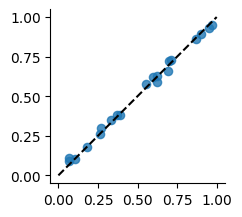

PPO


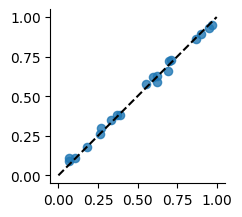

RLOO


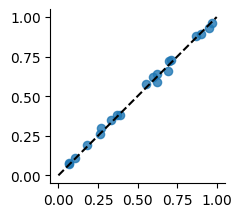

GRPO


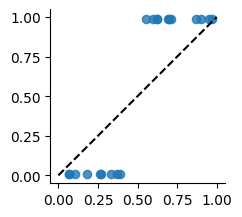

GRPO_no_std


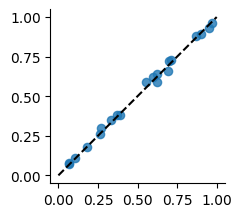

REINFORCE (offline)


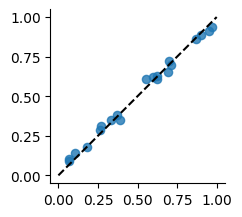

PPO (offline)


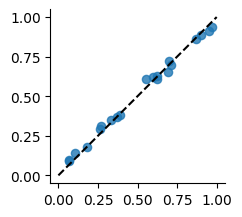

RLOO (offline)


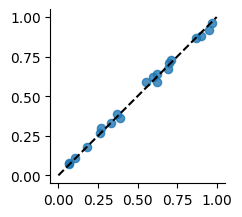

GRPO (offline)


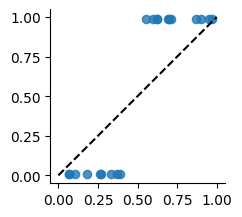

GRPO_no_std (offline)


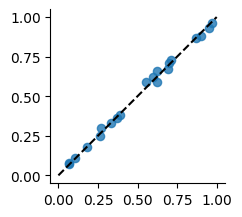

REINFORCE (offline+clip_0.001)


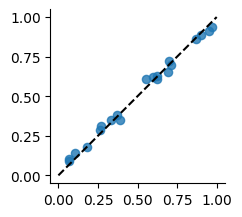

PPO (offline+clip_0.001)


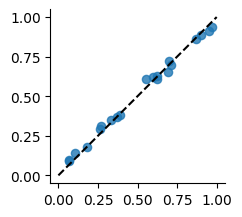

RLOO (offline+clip_0.001)


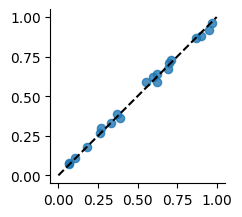

GRPO (offline+clip_0.001)


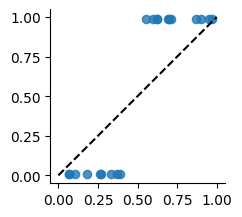

GRPO_no_std (offline+clip_0.001)


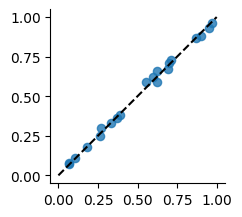

In [18]:
for k in results:
    model = results[k]["model"]
    a_cat_probs = torch.softmax(model.a_cat_given_t_logits.detach().cpu(), dim=-1)
    pred_probs = torch.matmul(a_cat_probs, torch.linspace(0.01, 0.99, 99)).numpy()
    plt.figure(figsize=(2.5, 2.5))
    # plt.title(k)
    print(k)
    plt.scatter(c_probs, pred_probs, s=35, alpha=0.8)
    plt.gca().spines[["right", "top"]].set_visible(False)
    plt.xticks([0, 0.25, 0.5, 0.75, 1])
    plt.yticks([0, 0.25, 0.5, 0.75, 1])
    plt.plot([0, 1], [0, 1], "k--")
    plt.gca().set_aspect("equal")
    plt.tight_layout()
    plt.savefig(fig_dir / f"pred_{k}.png", dpi=200, transparent=True, bbox_inches="tight")
    plt.show(plt.gcf())
    plt.close()

In [19]:
metric_keys = ["reward_mean", "frac_clipped", "ece", "auroc", "accuracy"]
metric_display_names = ["Reward Mean", "Frac. Clipped", "ECE", "AUROC", "Accuracy"]
plot_algos = ["PPO", "RLOO", "GRPO", "GRPO_no_std"]
plot_results = {}
plot_results["online"] = {k: results[k] for k in plot_algos}
plot_results["offline"] = {k: results[f"{k} (offline)"] for k in plot_algos}
plot_results["offline+clip=0.001"] = {k: results[f"{k} (offline+clip_0.001)"] for k in plot_algos}

In [20]:
plot_results["online"]["PPO"]["metrics"]

,step,metric,value
0,0,reward_mean,-0.967623
1,0,pred_entropy,0.729088
2,0,accuracy,0.502000
3,0,auroc,0.505263
4,0,ece,0.244815
...,...,...,...
1,49998,frac_clipped,0.000000
2,49998,pg_loss,0.095239
0,49999,value_loss,0.225656
1,49999,frac_clipped,0.000000


online


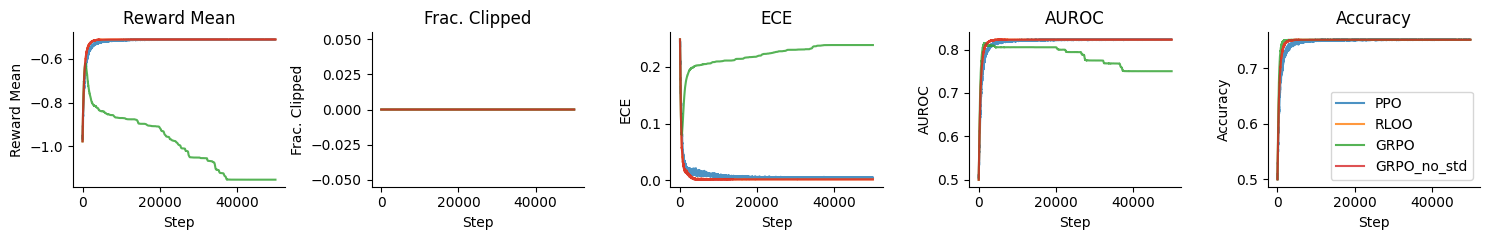

offline


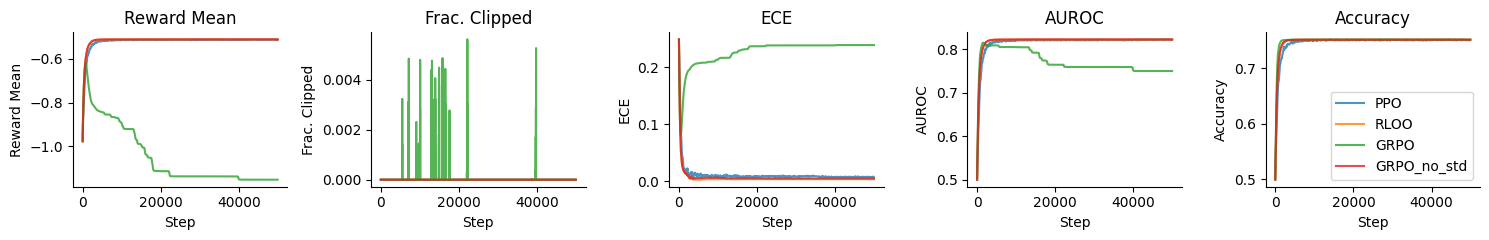

offline+clip=0.001


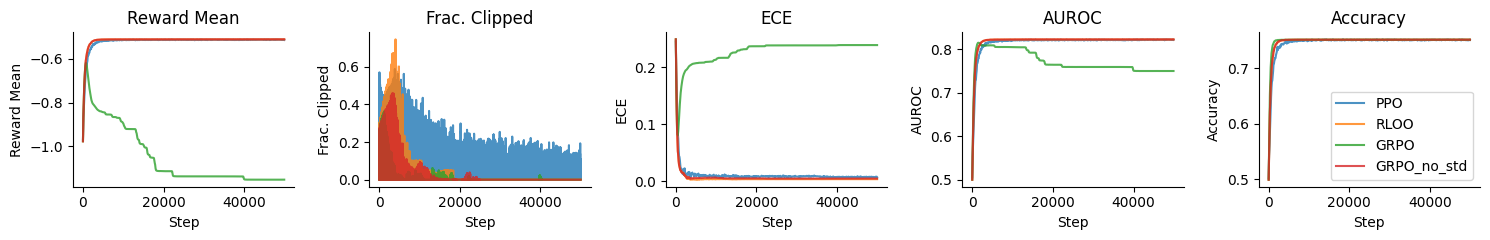

In [21]:
for k in plot_results:
    print(k)
    fig, axes = plt.subplots(figsize=(len(metric_keys)*3, 2.5), nrows=1, ncols=len(metric_keys))
    for i, ax in enumerate(axes.flat):
        metric = metric_keys[i]
        ax.set_title(metric_display_names[i])
        for algo in plot_algos:
            curr = plot_results[k][algo]["metrics"]
            curr = curr[curr["metric"] == metric]
            ax.plot(curr["step"], curr["value"], label=algo, alpha=0.8)
            ax.set_xlabel("Step")
            ax.set_ylabel(metric_display_names[i])
        ax.spines[["right", "top"]].set_visible(False)
    plt.legend()
    plt.tight_layout()
    plt.savefig(fig_dir / f"train_metrics_{k}.png", dpi=200, transparent=True)
    plt.show(fig)
    plt.close()